In [2]:
import os
from glob import glob
from tqdm import tqdm
from pathlib import Path
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.stats import calculate_p

In [3]:
perturbations = ['shuffled', 'no nouns', 'no verbs', 'only nouns', 'only verbs']
annotated_features = ['expanse', 'object', 
                 'agent distance', 'facingness', 'joint action', 
                 'communication', 'valence', 'arousal']
rois = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS', 'FFA', 'PPA']

def add_perturbation(file_, df_):
    if 'none' in file_:
        df_['perturbation'] = 'original'
    elif 'mask_nonverbs' in file_:
        df_['perturbation'] = 'only verbs'
    elif 'mask_nonnouns' in file_:
        df_['perturbation'] = 'only nouns'
    elif 'mask_nouns' in file_:
        df_['perturbation'] = 'no nouns'
    elif 'mask_verbs' in file_:
        df_['perturbation'] = 'no verbs'
    else:
        df_['perturbation'] = 'shuffled'
    return df_


def plot_perturbation_summary(df_, category, 
                              reliability_=None, out_file=None, stats=None,
                              y_var='test_score', y_label='Score ($r$)', 
                              palette_name=None):
    if palette_name is None:
        palette = sns.color_palette("husl", df_.perturbation.nunique())
    else:
        palette = sns.color_palette(palette_name, df_.perturbation.nunique())
    _, ax = plt.subplots(figsize=(8.5,4))
    color = ['gray', 'gray', 'gray']
    sns.stripplot(x=category, y=y_var, hue='perturbation', data=df_,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  zorder=1, palette=palette)
    sns.barplot(x=category, y=y_var, hue='perturbation', data=df_,
                dodge=True, saturation=.25, errorbar=None,
                legend=False, zorder=0, palette=palette)
    if reliability_ is not None:
        sns.pointplot(x=category, y='reliability', data=reliability_,
                      ax=ax, linestyle="none", errorbar=None, 
                      marker="_", markersize=30, markeredgewidth=7,
                      color='gray', alpha=.5, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(y_label)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              ncol=1, fancybox=True)
    if out_file is not None:
        plt.tight_layout()
        plt.savefig(out_file)

In [16]:
df = []
for file in glob('../data/interim/ModelAveraging/*LanguageBehaviorEncoding*pkl.gz'):
    df.append(add_perturbation(file, pd.read_pickle(file)))
df = pd.concat(df)
rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in df.feature.unique()}
df['feature'] = df['feature'].replace(rename_mapping)
df.set_index(['perturbation', 'feature'], inplace=True)

stats = []
for perturbation in perturbations:
    for feature in annotated_features:
        null_diff = df.loc['original', feature]['r_null_dist'] - df.loc[perturbation, feature]['r_null_dist'] 
        diff = df.loc['original', feature]['test_score'] - df.loc[perturbation, feature]['test_score']
        p = calculate_p(null_diff, diff, n_perm_=len(null_diff), H0_='greater')
        stats.append({'perturbation': perturbation, 'feature': feature, 'p': p})
stats = pd.DataFrame(stats)
stats['perturbation'] = pd.Categorical(stats['perturbation'], categories=['original']+perturbations, ordered=True)
stats['feature'] = pd.Categorical(stats['feature'], categories=annotated_features, ordered=True)
stats.sort_values(by=['feature', 'perturbation'], inplace=True)
stats.set_index(['feature'], inplace=True)

stats['sig_text'] = 'none'
stats.loc[(0.05 > stats.p) & (stats.p >= 0.01), 'sig_text'] = '*'
stats.loc[(0.01 > stats.p) & (stats.p >= 0.001), 'sig_text'] = '**'
stats.loc[(0.001 > stats.p), 'sig_text'] = '***'

In [17]:
run_summary = False
if run_summary: 
    for perturb in ['none', 'shuffle', 'mask_nouns', 'mask_verbs', 'mask_nonnouns', 'mask_nonverbs']:
        os.system(f'ml anaconda; conda activate deepjuice; python ../scripts/model_summary.py --model_class LanguageBehaviorEncoding --model_subpath {perturb}')

df = []
for file in glob('../data/interim/ModelSummary/*LanguageBehaviorEncoding*csv.gz'):
    df.append(add_perturbation(file, pd.read_csv(file)))
df = pd.concat(df)
df = df.loc[df.set == 'test'].reset_index(drop=True)
df['perturbation'] = pd.Categorical(df['perturbation'], categories=['original']+perturbations, ordered=True)
df['feature'] = pd.Categorical(df['feature'], categories=annotated_features, ordered=True)

In [19]:
behavior_reliability = pd.read_csv(f'../data/interim/ReorganizeBehavior/metadata.csv')
behavior_reliability.replace({'agent_distance': 'agent distance', 'joint_action': 'joint action'}, inplace=True)
behavior_reliability['feature'] = pd.Categorical(behavior_reliability['feature'], categories=annotated_features, ordered=True)

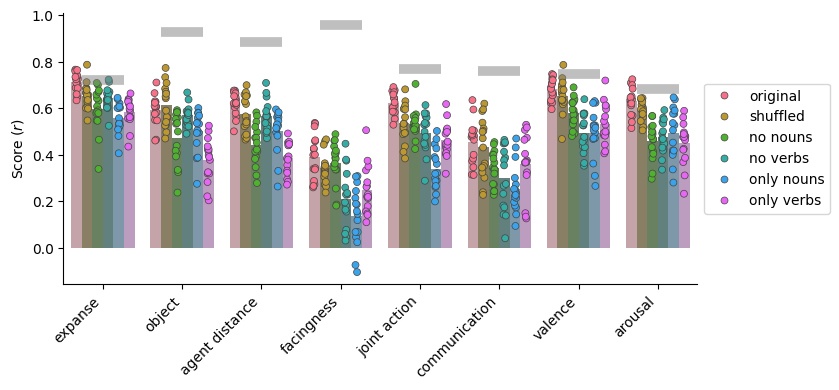

In [20]:
plot_perturbation_summary(df, reliability_=behavior_reliability,
                          stats=stats,
                          y_var='score',
                          out_file='../reports/figures/ResultsSummary/behavior_pertubations.pdf')

In [10]:
neural_metadata = pd.read_csv('../data/interim/ReorganziefMRI/metadata.csv')
neural_metadata.head()

,voxel_id,roi_name,stream_name,subj_id,reliability,i_index,j_index,k_index
0,0,none,none,1,0.322961,2,33,31
1,1,none,none,1,0.340669,2,33,32
2,2,none,none,1,0.313496,2,34,35
3,3,none,none,1,0.254933,2,35,31
4,4,none,none,1,0.300477,2,36,36


In [8]:
df.merge(neural_metadata, on='voxel_id')
df.set_index(['perturbation', 'roi_name'], inplace=True)

KeyError: "None of ['roi_name'] are in the columns"

In [4]:
run_averaging = False
if run_averaging: 
    for perturb in ['none', 'shuffle', 'mask_nouns', 'mask_verbs', 'mask_nonnouns', 'mask_nonverbs']:
        os.system(f'ml anaconda; conda activate deepjuice; python ../scripts/model_averaging.py --model_class LanguageNeuralEncoding --model_subpath {perturb}')

df = []
for file in glob('../data/interim/ModelAveraging/*LanguageNeuralEncoding*pkl.gz'):
    df.append(add_perturbation(file, pd.read_pickle(file)))
df = pd.concat(df)

stats = []
for roi in rois:
    for feature in annotated_features:
        null_diff = df.loc['original', roi]['r_null_dist'] - df.loc[perturbation, roi]['r_null_dist'] 
        diff = df.loc['original', roi]['test_score'] - df.loc[perturbation, roi]['test_score']
        p = calculate_p(null_diff, diff, n_perm_=len(null_diff), H0_='greater')
        stats.append({'perturbation': perturbation, 'roi_name': roi, 'p': p})
stats = pd.DataFrame(stats)
stats['perturbation'] = pd.Categorical(stats['perturbation'], categories=['original']+perturbations, ordered=True)
stats['roi_name'] = pd.Categorical(stats['roi_name'], categories=rois, ordered=True)
stats.sort_values(by=['roi_name', 'perturbation'], inplace=True)
stats.set_index(['roi'], inplace=True)

stats['sig_text'] = 'none'
stats.loc[(0.05 > stats.p) & (stats.p >= 0.01), 'sig_text'] = '*'
stats.loc[(0.01 > stats.p) & (stats.p >= 0.001), 'sig_text'] = '**'
stats.loc[(0.001 > stats.p), 'sig_text'] = '***'

KeyError: 'original'

In [ ]:
run_summary = False
if run_summary: 
    for perturb in ['none', 'shuffle', 'mask_nouns', 'mask_verbs', 'mask_nonnouns', 'mask_nonverbs']:
        os.system(f'ml anaconda; conda activate deepjuice; python ../scripts/model_summary.py --model_class LanguageNeuralEncoding --model_subpath {perturb}')

df = []
for file in glob('../data/interim/ModelSummary/*LanguageNeuralEncoding*csv.gz'):
    df.append(add_perturbation(file, pd.read_csv(file)))
df = pd.concat(df)
df = df.loc[df.set == 'test'].reset_index(drop=True)
df['perturbation'] = pd.Categorical(df['perturbation'], categories=['original']+perturbations, ordered=True)
df['roi_name'] = pd.Categorical(df['roi_name'], categories=rois, ordered=True)

In [ ]:
plot_perturbation_summary(df, 'roi_name', 
                          y_var='score',
                          out_file='../reports/figures/ResultsSummary/neural_pertubations.pdf')